<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 40px;'>🚀</span>
  <span style='font-weight: bold; font-size: 32px; color: #2C4C65;'>TRM Extra Mile | Data Scientist</span>
</div>
<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-weight: normal; font-size: 19px; color: #F;'>Data Analysis</span>
</div>

<br><br>

<div style='color: #2C4C65; text-align: center; font-size: 28px; font-weight: bold'>
  <p>
    Content
  </p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Model results and Evaluation of performance</p>
</div>

In [1]:
import yaml
with open('../utils/variables.yml', 'r') as file:
    variables = yaml.safe_load(file)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #2C4C65;'>Data splits based on dates</span>
</div>

<br>

In [2]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath(".."))
from utils.plots import plotter as ptz

from utils.models import (
    score_interval_evaluation,
    plot_confusion_matrix,
    calculate_gains
)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split        
from lightgbm import LGBMClassifier, early_stopping 
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

# Reading data from data folder
df = pd.read_csv('../data/bronze_data.csv').drop(['Unnamed: 0'],axis=1)
df = df[variables['columns_keepers']]
df['BTC'] = df.apply(lambda x: x['income']/1_000_000, axis=1)

df['date_operation'] = pd.to_datetime(df['date_operation'])
df['month_year'] = df.apply(lambda x: str(x['date_operation'].month) + '_' + str(x['date_operation'].year), axis=1)

In [3]:
df_train = df[
    (df['date_operation'] > '05-01-2014') &
    (df['date_operation'] <= '01-01-2017')
]

df_val = df[
    (df['date_operation'] >= '01-01-2017') &
    (df['date_operation'] <= '03-01-2017')
]

df_test = df[
    (df['date_operation'] > '03-01-2017') &
    (df['date_operation'] < '06-01-2017')
]

date_train = df_train[['date_operation']]
btc_train = df_train[['BTC']]
X_train = df_train[variables['columns_trainers']].drop(['target'],axis=1)
y_train = df_train[['target']]

date_val = df_val[['date_operation']]
btc_val = df_val[['BTC']]
X_val = df_val[variables['columns_trainers']].drop(['target'],axis=1)
y_val = df_val[['target']]

date_test = df_test[['date_operation']]
btc_test = df_test[['BTC']]
X_test = df_test[variables['columns_trainers']].drop(['target'],axis=1)
y_test = df_test[['target']]

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #2C4C65;'>Defining the best threshold for the classifier</span>
</div>

<br>

In [4]:
import pickle
with open('model.pkl', 'rb') as file:
    random_search = pickle.load(file)

y_pred = random_search.predict_proba(X_val)[:,1]
y_label_val = (y_pred >= 0.5).astype(int)
y_val.name = 'status_final_model'
score_interval_evaluation(
    target=y_val,
    predicted_probabilities=y_pred, 
    X_val=X_val,
    y_val=y_val
)

Index(['target'], dtype='object')


,score_interval,volumetria,acertos,volumetria_acc,acertos_acc,erros,erros_acc,prec_linha,recall_linha,percent_impact,percent_error,percent_acertos,prec_acc,recall_acc
20,"(0.95,1.00]",0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,"(0.90,0.95]",4,0,4.0,0.0,4,4.0,0.000000,0.000000,0.006505,0.006667,0.000000,0.000000,0.000000
18,"(0.85,0.90]",45,24,49.0,24.0,21,25.0,0.213931,0.005369,0.079688,0.041667,1.610738,0.489796,0.016107
17,"(0.80,0.85]",118,45,167.0,69.0,73,98.0,0.458458,0.035839,0.271589,0.163333,4.630872,0.413174,0.046309
16,"(0.75,0.80]",155,60,322.0,129.0,95,193.0,0.408226,0.067651,0.523662,0.321667,8.657718,0.400621,0.086577
15,"(0.70,0.75]",198,91,520.0,220.0,107,300.0,0.410115,0.117181,0.845666,0.500000,14.765101,0.423077,0.147651
14,"(0.65,0.70]",253,110,773.0,330.0,143,443.0,0.432352,0.195705,1.257115,0.738333,22.147651,0.426908,0.221477
13,"(0.60,0.65]",231,74,1004.0,404.0,157,600.0,0.410333,0.249799,1.632786,1.000000,27.114094,0.402390,0.271141
12,"(0.55,0.60]",250,56,1254.0,460.0,194,794.0,0.382852,0.295168,2.039356,1.323333,30.872483,0.366826,0.308725
11,"(0.50,0.55]",322,54,1576.0,514.0,268,1062.0,0.345896,0.330336,2.563018,1.770000,34.496644,0.326142,0.344966


In [5]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)

dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_val)

print(classification_report(y_true=y_val, y_pred=y_pred_dummy))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     60000
           1       0.02      0.02      0.02      1490

    accuracy                           0.95     61490
   macro avg       0.50      0.50      0.50     61490
weighted avg       0.95      0.95      0.95     61490



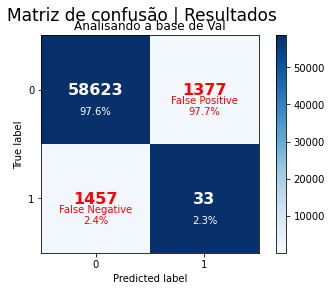

In [6]:
plot_confusion_matrix(
    y_true=y_val, 
    y_pred=y_pred_dummy, 
    split='Val', 
    position_title=0.475
)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #2C4C65;'>Monetary and Quantity Results from the model</span>
</div>

<br>

In [7]:
calculate_gains(
    df=X_val.copy(),
    target=y_val,
    predicted_label=y_label_val,
    value_risk=btc_val
)

###############
> The model correctly identified 520 of ransonware operations
> The model could have saved 52924.985310000004 of BTC in ransonware operations in seconds
> The model found 1089 suspect operations of ransonware that are not classified as ransonwares, this may raise a flag of how the current process is not effective and TRM Labs could improve the system
> The model found 197698.115113 of BTC from suspect operations of ransonware that are not classified as ransonwares in ransonware operations as mentioned above
###############
